In [1]:
from zipline import run_algorithm
import matplotlib.pyplot as plt
import math
from zipline.api import (order_target_percent,symbol,set_commission,set_benchmark,order,record)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from zipline.api import order_target, record, symbol, set_commission, set_slippage, set_long_only,order_target_percent, order, schedule_function,  date_rules,time_rules
from zipline.finance import commission
import warnings
import matplotlib.pyplot as plt
from zipline.utils.calendar_utils import get_calendar
# import talib
# from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
from zipline.utils.run_algo import load_extensions
#from utils.utils import *
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, INFO, WARNING, DEBUG, ERROR)
import pytz
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [2]:
import yfinance as yf

In [3]:
%load_ext zipline

In [4]:
start_date = '2010-01-01'
end_date = '2022-07-01'
sp100_stocks =  yf.download("^OEX" , start = start_date , end  = end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
sp100_stocks.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,514.739990,523.299988,514.739990,522.729980,522.729980,3991400000
2010-01-05,522.630005,524.700012,521.280029,524.599976,524.599976,2491020000
2010-01-06,524.150024,525.359985,523.090027,524.309998,524.309998,4972660000
2010-01-07,523.950012,526.820007,521.630005,526.340027,526.340027,5270680000
2010-01-08,525.789978,527.940002,524.270020,527.760010,527.760010,4389590000
2010-01-11,528.260010,529.739990,526.299988,528.609985,528.609985,4255780000
2010-01-12,526.940002,526.940002,522.289978,524.289978,524.289978,4716160000
2010-01-13,524.729980,529.419983,522.900024,527.929993,527.929993,4170360000
2010-01-14,527.929993,530.739990,527.500000,529.599976,529.599976,3915200000


In [6]:
sp100_stocks.to_csv("S&P100_stocks.csv")

In [7]:
sp100_stocks= pd.read_csv("S&P100_stocks.csv")
sp100_stocks = sp100_stocks.drop('Adj Close', axis = 1)
sp100_stocks.head(5)

,Date,Open,High,Low,Close,Volume
0,2010-01-04,514.739990,523.299988,514.739990,522.729980,3991400000
1,2010-01-05,522.630005,524.700012,521.280029,524.599976,2491020000
2,2010-01-06,524.150024,525.359985,523.090027,524.309998,4972660000
3,2010-01-07,523.950012,526.820007,521.630005,526.340027,5270680000
4,2010-01-08,525.789978,527.940002,524.270020,527.760010,4389590000


In [8]:
upDatedColumns = {'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}
sp100_stocks.rename(columns = upDatedColumns , inplace = True)
sp100_stocks.head()

,date,open,high,low,close,volume
0,2010-01-04,514.739990,523.299988,514.739990,522.729980,3991400000
1,2010-01-05,522.630005,524.700012,521.280029,524.599976,2491020000
2,2010-01-06,524.150024,525.359985,523.090027,524.309998,4972660000
3,2010-01-07,523.950012,526.820007,521.630005,526.340027,5270680000
4,2010-01-08,525.789978,527.940002,524.270020,527.760010,4389590000


In [9]:
sp100_stocks.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

In [10]:
sp100_stocks['volume'] = sp100_stocks['volume'].astype(float)

In [11]:
sp100_stocks.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [12]:
sp100_stocks['timestamp'] = pd.to_datetime(sp100_stocks['date'])
sp100_stocks = sp100_stocks.reindex(columns =['timestamp', 'open','high', 'low', 'close', 'volume'])
sp100_stocks['timestamp'] = sp100_stocks['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
sp100_stocks = sp100_stocks.sort_values(by='timestamp' , ascending = True)
sp100_stocks = sp100_stocks.reset_index(drop = True)
sp100_stocks

,timestamp,open,high,low,close,volume
0,2010-01-04 00:00:00.000000,514.739990,523.299988,514.739990,522.729980,3.991400e+09
1,2010-01-05 00:00:00.000000,522.630005,524.700012,521.280029,524.599976,2.491020e+09
2,2010-01-06 00:00:00.000000,524.150024,525.359985,523.090027,524.309998,4.972660e+09
3,2010-01-07 00:00:00.000000,523.950012,526.820007,521.630005,526.340027,5.270680e+09
4,2010-01-08 00:00:00.000000,525.789978,527.940002,524.270020,527.760010,4.389590e+09
...,...,...,...,...,...,...
3140,2022-06-24 00:00:00.000000,1747.989990,1790.260010,1747.989990,1789.199951,8.120260e+09
3141,2022-06-27 00:00:00.000000,1793.719971,1797.329956,1775.579956,1780.890015,4.325310e+09
3142,2022-06-28 00:00:00.000000,1785.569946,1801.699951,1739.979980,1740.599976,4.270120e+09
3143,2022-06-29 00:00:00.000000,1742.729980,1752.790039,1733.750000,1743.439941,4.211240e+09


In [13]:
sp100_stocks.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

In [14]:
sp100_stocks.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

In [15]:
sp100_stocks = sp100_stocks.groupby('timestamp').last().reset_index()
sp100_stocks

,timestamp,open,high,low,close,volume
0,2010-01-04 00:00:00.000000,514.739990,523.299988,514.739990,522.729980,3.991400e+09
1,2010-01-05 00:00:00.000000,522.630005,524.700012,521.280029,524.599976,2.491020e+09
2,2010-01-06 00:00:00.000000,524.150024,525.359985,523.090027,524.309998,4.972660e+09
3,2010-01-07 00:00:00.000000,523.950012,526.820007,521.630005,526.340027,5.270680e+09
4,2010-01-08 00:00:00.000000,525.789978,527.940002,524.270020,527.760010,4.389590e+09
...,...,...,...,...,...,...
3140,2022-06-24 00:00:00.000000,1747.989990,1790.260010,1747.989990,1789.199951,8.120260e+09
3141,2022-06-27 00:00:00.000000,1793.719971,1797.329956,1775.579956,1780.890015,4.325310e+09
3142,2022-06-28 00:00:00.000000,1785.569946,1801.699951,1739.979980,1740.599976,4.270120e+09
3143,2022-06-29 00:00:00.000000,1742.729980,1752.790039,1733.750000,1743.439941,4.211240e+09


In [16]:
sp100_stocks.set_index('timestamp',inplace = True)
sp100_stocks.to_csv("/home/shbmsk/Desktop/AnchorBlock Technology/Task - 2/Data/daily/sp100_stocks.csv")

In [17]:
!zipline bundles

csvdir <no ingestions>
quandl 2023-12-09 22:31:26.889602
quantopian-quandl <no ingestions>
spStocks 2023-12-18 19:21:03.859693
spStocks 2023-12-14 09:02:33.218199
spStocks 2023-12-13 00:51:42.437904


In [18]:
!zipline ingest -b spStocks

[2023-12-19T01:47:23+0600-INFO][zipline.data.bundles.core]
 Ingesting spStocks
Loading custom pricing data:   [------------------------------------]    0%/home/shbmsk/anaconda3/lib/python3.10/site-packages/zipline/data/bcolz_daily_bars.py:341: UserWarning: Ignoring 811 values because they are out of bounds for uint32:
                    open         high          low        close        volume
timestamp                                                                   
2010-01-06   524.150024   525.359985   523.090027   524.309998  4.972660e+09
2010-01-07   523.950012   526.820007   521.630005   526.340027  5.270680e+09
2010-01-08   525.789978   527.940002   524.270020   527.760010  4.389590e+09
2010-01-12   526.940002   526.940002   522.289978   524.289978  4.716160e+09
2010-01-15   529.390015   529.400024   522.059998   524.109985  4.758730e+09
...                 ...          ...          ...          ...           ...
2022-06-22  1708.819946  1738.569946  1700.729980  1718.170044 

In [19]:
%matplotlib inline 
%load_ext zipline
%load_ext autoreload
%autoreload 2

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [20]:
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
calendar

In [21]:
def rolling_sharpe(ret):
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    #stats = [math.log(result.rolling_sharpe.mean())/result.rolling_sharpe.std(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    #rolling_sharpe = result["rolling_sharpe"].dropna().values

    if (result["rolling_sharpe"].dropna().values <= 0).any():
        # Handle case where Sharpe ratio is non-positive
        stats = [float('nan'), result.portfolio_value.mean(), result.rolling_vol.mean()]
    else:
        stats = [math.log(rolling_sharpe.mean())/rolling_sharpe.std(), result.portfolio_value.mean(), result.rolling_vol.mean()]

    return result, stats



def show_rolling_stats(result, r_window, buy_signal=None, sell_signal=None):
    result, stats = get_rolling_stats(result, r_window)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Plot rolling Sharpe ratio
    result["rolling_sharpe"].plot(ax=ax[0], title="Rolling sharpe")
    ax[0].axhline(0, color="red", ls="--")

    # Plot rolling volatility
    result["rolling_vol"].plot(ax=ax[1], title="Rolling vol")

    # Create a new figure and plot BTC price and portfolio value in separate subplots
    fig2, ax2 = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

    # Plot BTC price in the first subplot
    result[["Kor_gold"]].plot(ax=ax2[0], color="green", label=" Price")
    ax2[0].set_title("Price")
    ax2[0].set_ylabel("Price")

    # Plot buy and sell signals as dots in the BTC price subplot
    if buy_signal is not None:
        buy_mask = buy_signal == True
        result.loc[buy_mask, "Kor_gold"].plot(
            ax=ax2[0], 
            color="yellow", 
            marker="^",
            linestyle='None',
            label="Long (buy)"
        )

    if sell_signal is not None:
        sell_mask = sell_signal == True
        result.loc[sell_mask, "Kor_gold"].plot(
            ax=ax2[0], 
            color="red", 
            marker="v",
            linestyle='None',
            label="Short (sell)"
        )

    # Add legend to the subplot
    ax2[0].legend()

    # Plot portfolio value in the second subplot
    ax2[1].set_title("Portfolio value")
    ax2[1].set_ylabel("Portfolio value")
    result["portfolio_value"].plot(ax=ax2[1], color="blue", label="Portfolio value")

    # Add legend to the subplot
    ax2[1].legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

    return result



In [22]:

def EMA(day, price_hist):
    #price_hist = price_hist.tolist()
    multiplier = 2 / (day + 1)
    EMA_list = []
    EMA_prev = price_hist[0]
    EMA_list.append(EMA_prev)
    for price in price_hist[1:]:
        EMA = (price - EMA_prev) * multiplier + EMA_prev
        EMA_list.append(EMA)
        EMA_prev = EMA
    return EMA_list


In [23]:

def initialize(context):
    context.i = 0
    context.asset = symbol("sp100_stocks")


def handle_data(context, data):
    context.i += 1
    if context.i < 1:
        return
    buy_signal = False
    sell_signal = False
    price_hist = data.history(context.asset, 'close', bar_count =15, frequency ='1d')     # Ideally for MACD 26,12,9 days are used, I use here 14,7,5 days
    EMA_20 = EMA(14, price_hist)
    EMA_5 = EMA(7, price_hist)
    MACD = [EMA_20[i] - EMA_5[i] for i in range(len(price_hist))]
    signal = EMA(5,MACD)
    if MACD[-1] > signal[-1] and MACD[-2] < signal[-2]:    #Bull
        order(context.asset, 1)
        buy_signal = True
    elif MACD[-1] < signal[-1] and MACD[-2] > signal[-2]:  #Bear
        order(context.asset, -1)
        sell_signal = True
    record(
        Kor_gold=data.current(context.asset, "close"),
        MACD=MACD[-1],
        signal=signal[-1],
        sell_signal = sell_signal,
        buy_signal = buy_signal,
        price_hist=price_hist
    )

In [24]:
def analyze(context, perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns,benchmark_rets=None,return_fig=True)
    plt.savefig('backtest_macd.png')

In [25]:
start_date = pd.to_datetime('2010-11-22 00:00:00.0000', format = '%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2019-05-02 00:00:00.0000',format = '%Y-%m-%d %H:%M:%S.%f')
results = run_algorithm(start=start_date,
                            end=end_date,
                            initialize=initialize,
                            #analyze=analyze,
                            handle_data=handle_data,
                            capital_base=10000,
                            benchmark_returns=None,
                            trading_calendar=calendar,
                            bundle='spStocks',
                            data_frequency='daily',
                            )

/tmp/ipykernel_42844/1834308575.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  EMA_prev = price_hist[0]
/tmp/ipykernel_42844/1834308575.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  EMA_prev = price_hist[0]
/home/shbmsk/anaconda3/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/tmp/ipykernel_42844/183

In [26]:
results

,period_open,period_close,ending_cash,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,...,benchmark_volatility,algorithm_period_return,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return
2010-11-22 21:00:00+00:00,2010-11-22 14:31:00+00:00,2010-11-22 21:00:00+00:00,10000.000000,10000.000000,0,0,0.00,0.00,0.00,0.000000,...,NaN,0.000000,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0
2010-11-23 21:00:00+00:00,2010-11-23 14:31:00+00:00,2010-11-23 21:00:00+00:00,10000.000000,10000.000000,0,0,0.00,0.00,0.00,0.000000,...,0.0,0.000000,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0
2010-11-24 21:00:00+00:00,2010-11-24 14:31:00+00:00,2010-11-24 21:00:00+00:00,10000.000000,10000.000000,0,0,0.00,0.00,0.00,0.000000,...,0.0,0.000000,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0
2010-11-26 18:00:00+00:00,2010-11-26 14:31:00+00:00,2010-11-26 18:00:00+00:00,10533.322205,9999.732205,0,1,0.00,-533.59,0.00,-0.267795,...,0.0,-0.000027,None,None,-7.937254,-7.937254,-0.000027,0.053360,0.0,0.0
2010-11-29 21:00:00+00:00,2010-11-29 14:31:00+00:00,2010-11-29 21:00:00+00:00,10533.322205,9999.892205,0,1,0.00,-533.43,0.00,0.160000,...,0.0,-0.000011,None,None,-2.220745,-2.857552,-0.000027,0.053360,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26 20:00:00+00:00,2019-04-26 13:31:00+00:00,2019-04-26 20:00:00+00:00,-7686.291335,19700.858665,1,0,27387.15,0.00,27387.15,117.810000,...,0.0,0.970086,None,None,0.620780,0.869160,-0.272156,1.620123,0.0,0.0
2019-04-29 20:00:00+00:00,2019-04-29 13:31:00+00:00,2019-04-29 20:00:00+00:00,-7686.291335,19762.178665,1,0,27448.47,0.00,27448.47,61.320000,...,0.0,0.976218,None,None,0.623131,0.872469,-0.272156,1.620123,0.0,0.0
2019-04-30 20:00:00+00:00,2019-04-30 13:31:00+00:00,2019-04-30 20:00:00+00:00,-7686.291335,19722.908665,1,0,27409.20,0.00,27409.20,-39.270000,...,0.0,0.972291,None,None,0.621373,0.870002,-0.272156,1.620123,0.0,0.0
2019-05-01 20:00:00+00:00,2019-05-01 13:31:00+00:00,2019-05-01 20:00:00+00:00,-7686.291335,19565.198665,1,0,27251.49,0.00,27251.49,-157.710000,...,0.0,0.956520,None,None,0.614664,0.860479,-0.272156,1.620123,0.0,0.0


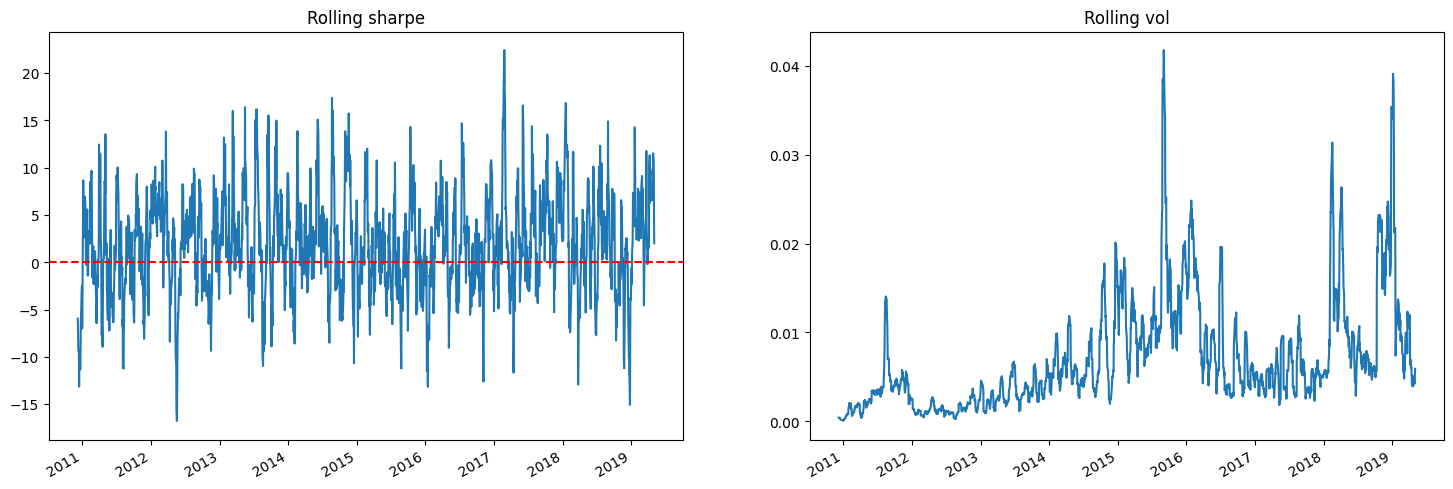

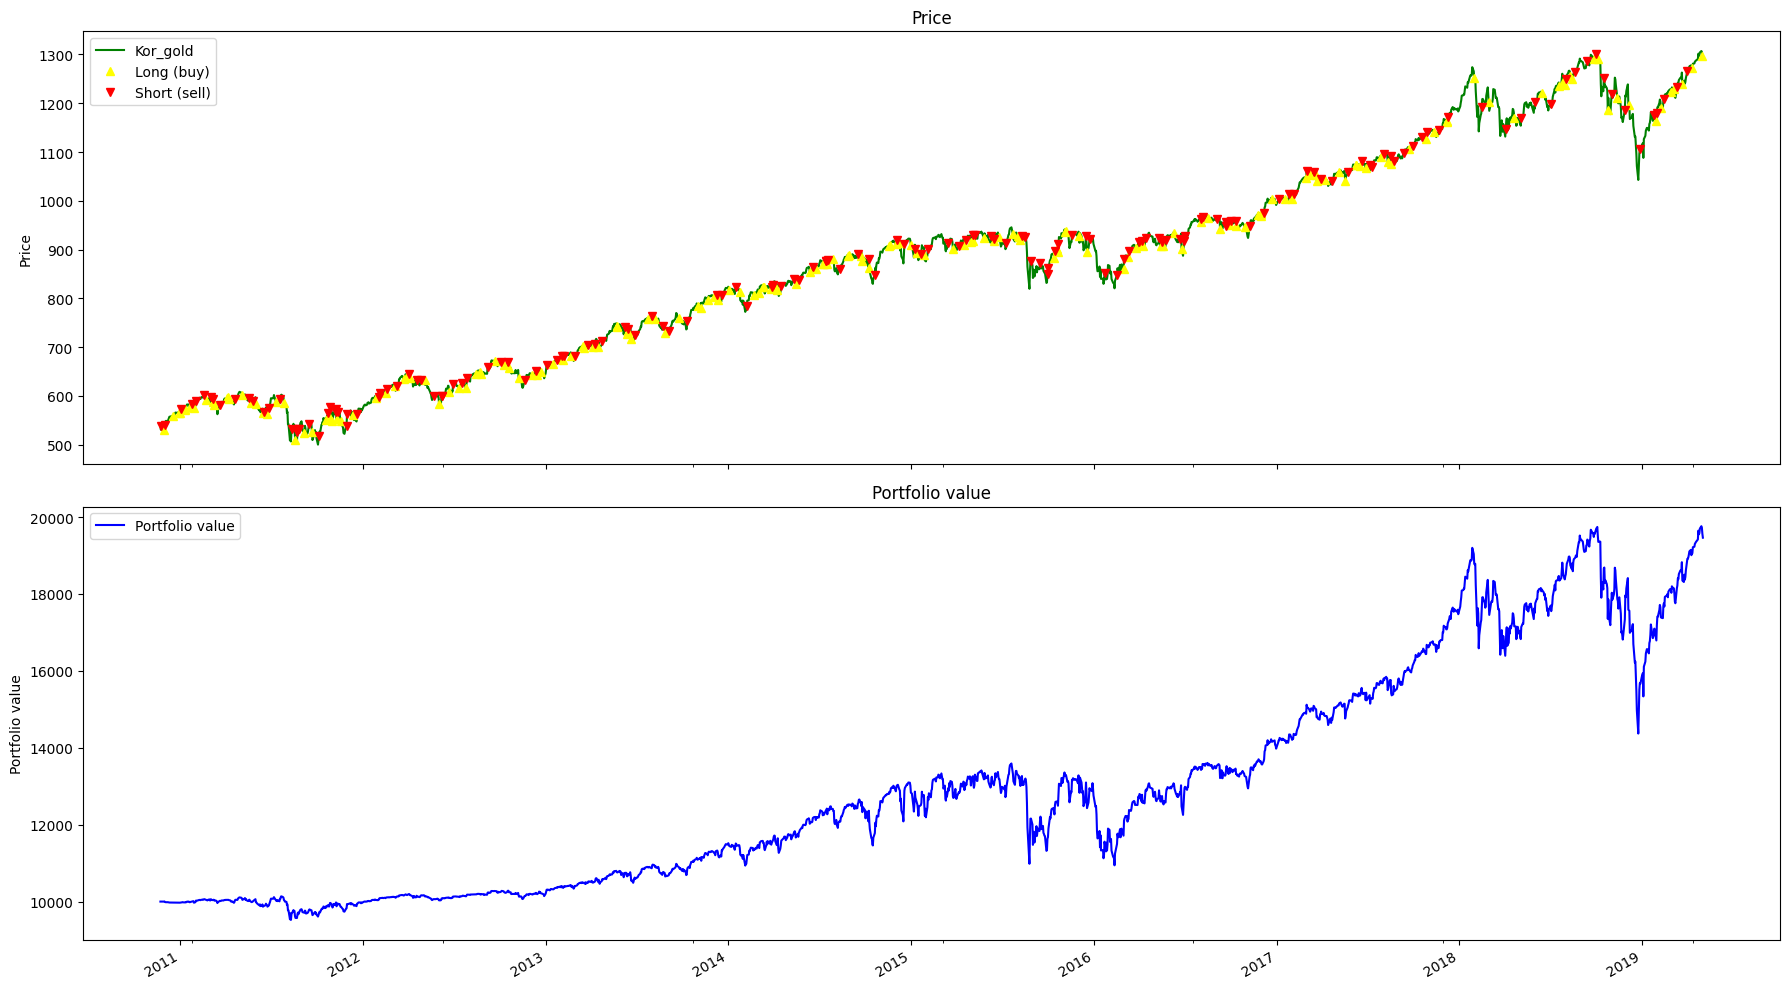

,period_open,period_close,ending_cash,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,...,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,rolling_sharpe,rolling_vol
2010-11-22 21:00:00+00:00,2010-11-22 14:31:00+00:00,2010-11-22 21:00:00+00:00,10000.000000,10000.000000,0,0,0.00,0.00,0.00,0.000000,...,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0,NaN,NaN
2010-11-23 21:00:00+00:00,2010-11-23 14:31:00+00:00,2010-11-23 21:00:00+00:00,10000.000000,10000.000000,0,0,0.00,0.00,0.00,0.000000,...,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0,NaN,NaN
2010-11-24 21:00:00+00:00,2010-11-24 14:31:00+00:00,2010-11-24 21:00:00+00:00,10000.000000,10000.000000,0,0,0.00,0.00,0.00,0.000000,...,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0,NaN,NaN
2010-11-26 18:00:00+00:00,2010-11-26 14:31:00+00:00,2010-11-26 18:00:00+00:00,10533.322205,9999.732205,0,1,0.00,-533.59,0.00,-0.267795,...,None,None,-7.937254,-7.937254,-0.000027,0.053360,0.0,0.0,NaN,NaN
2010-11-29 21:00:00+00:00,2010-11-29 14:31:00+00:00,2010-11-29 21:00:00+00:00,10533.322205,9999.892205,0,1,0.00,-533.43,0.00,0.160000,...,None,None,-2.220745,-2.857552,-0.000027,0.053360,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26 20:00:00+00:00,2019-04-26 13:31:00+00:00,2019-04-26 20:00:00+00:00,-7686.291335,19700.858665,1,0,27387.15,0.00,27387.15,117.810000,...,None,None,0.620780,0.869160,-0.272156,1.620123,0.0,0.0,11.526695,0.004582
2019-04-29 20:00:00+00:00,2019-04-29 13:31:00+00:00,2019-04-29 20:00:00+00:00,-7686.291335,19762.178665,1,0,27448.47,0.00,27448.47,61.320000,...,None,None,0.623131,0.872469,-0.272156,1.620123,0.0,0.0,10.522092,0.004242
2019-04-30 20:00:00+00:00,2019-04-30 13:31:00+00:00,2019-04-30 20:00:00+00:00,-7686.291335,19722.908665,1,0,27409.20,0.00,27409.20,-39.270000,...,None,None,0.621373,0.870002,-0.272156,1.620123,0.0,0.0,9.086325,0.004464
2019-05-01 20:00:00+00:00,2019-05-01 13:31:00+00:00,2019-05-01 20:00:00+00:00,-7686.291335,19565.198665,1,0,27251.49,0.00,27251.49,-157.710000,...,None,None,0.614664,0.860479,-0.272156,1.620123,0.0,0.0,3.948071,0.005529


In [27]:
show_rolling_stats(results, 10, buy_signal=results['buy_signal'], sell_signal=results['sell_signal'])

In [ ]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.tears import create_full_tear_sheet
 
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
 
create_full_tear_sheet(returns, positions=positions, transactions=transactions)

/home/shbmsk/anaconda3/lib/python3.10/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.222%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2010-11-22
End date,2019-05-02
Total months,101
,Backtest
Annual return,8.222%
Cumulative returns,94.635%
Annual volatility,14.729%
Sharpe ratio,0.61
Calmar ratio,0.30
Stability,0.92
Max drawdown,-27.216%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.22,2018-10-03,2018-12-24,2019-04-29,149
1,19.48,2015-07-20,2016-02-11,2016-08-15,281
2,14.62,2018-01-26,2018-04-02,2018-08-27,152
3,9.46,2014-09-19,2014-10-16,2014-11-06,35
4,7.30,2014-12-05,2014-12-16,2014-12-23,13


/home/shbmsk/anaconda3/lib/python3.10/site-packages/pyfolio/plotting.py:1373: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(
/home/shbmsk/anaconda3/lib/python3.10/site-packages/pyfolio/plotting.py:1401: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.02%,-2.42%,1.65%
Fukushima,0.00%,-0.38%,0.26%
EZB IR Event,-0.00%,-0.25%,0.34%
Apr14,0.05%,-2.30%,1.23%
Oct14,0.09%,-2.52%,2.30%
Fall2015,-0.34%,-5.98%,6.71%
Recovery,0.00%,-2.42%,1.65%
New Normal,0.05%,-5.98%,6.71%


Top 10 long positions of all time,max
sid,
SP100_STOCKS,162.01%


Top 10 short positions of all time,max
sid,
SP100_STOCKS,-5.61%


Top 10 positions of all time,max
sid,
SP100_STOCKS,162.01%


/home/shbmsk/anaconda3/lib/python3.10/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/home/shbmsk/anaconda3/lib/python3.10/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))


#Analysis Using Quantstats

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.font_manager
import quantstats as qs

In [ ]:
qs.stats.sharpe(returns)

In [ ]:
qs.plots.snapshot(returns, title='S&P100 Performance', show=True)

In [ ]:
qs.reports.full(returns)